# Project of the MNIST Data Using GAN Methods

## Load the useful packages

In [3]:
import scipy
import numpy as np # manipulate N-dimensional arrays
import pandas as pd # data frame
import matplotlib.pyplot as plt # data plotting
import matplotlib.gridspec as gridspec
import seaborn # advanced data plotting
from sklearn import preprocessing # basic ML models
# import scipy # scientific computing library
from tqdm import tqdm #progress bar
#import torch
import time
import os
import pickle
import tensorflow as tf
#from tensorflow.keras import layers, models

# example of semi-supervised gan for mnist
from numpy import expand_dims, zeros, ones, asarray
from numpy.random import randn, randint

from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Model, Sequential

from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout, Lambda, Activation
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from skimage.transform import resize
#from keras.utils import to_categorical

from matplotlib import pyplot as plt
from keras import backend as K
import numpy as np

In [4]:
device_list=tf.test.gpu_device_name()

In [5]:
device_list

'/device:GPU:0'

In [6]:
if device_list!='/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at:()'.format(device_list))

Found GPU at:()


In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Loading the data

In [ ]:
#from keras.datasets import mnist
#from keras import backend as K

In [ ]:
#K.set_image_data_format('channels_last')
#(x_train_original, y_train_original), (x_test, y_test) = mnist.load_data(path="mnist.npz")
#print('x_train shape:', x_train_original.shape)
#print(x_train_original.shape[0], 'train samples')
#print(y_train_original.shape, 'train samples')
#print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28)
60000 train samples
(60000,) train samples
10000 test samples


In [ ]:
# Check number of classes
#num_classes = y_train_original.max() +1
#num_classes

In [ ]:
#plt.imshow(x_test[1])

In [ ]:
# Check the class labels
#y_train_original

In [ ]:
#LABELS = {
    #0 : "Zero",
    #1 : "One",
    #2 : "Two",
    #3 : "Three",
    #4 : "Four",
    #5 : "Five",
    #6 : "Six",
    #7 : "Seven",
    #8 : "Eight",
    #9 : "Nine"
}

## Preprocessing

### Spliting the data

In [ ]:
#from sklearn.model_selection import train_test_split

In [ ]:
#x_train, x_val, y_train, y_val = train_test_split(x_train_original, y_train_original, test_size=10000, random_state=42, shuffle= True, stratify=y_train_original)

In [ ]:
#x_train.shape

In [ ]:
#x_val.shape

In [ ]:
#x_test.shape

In [ ]:
# Check number of samples inside each class
#from collections import Counter

In [ ]:
#Counter(list(y_train.reshape(-1)))

In [ ]:
#Counter(list(y_val.reshape(-1)))

In [ ]:
#Counter(list(y_test.reshape(-1)))

### Convert class vectors into binary class matrices

In [ ]:
#from tensorflow.keras.utils import to_categorical

In [ ]:
#y_train_original = to_categorical(y_train_original, num_classes)
#y_test = to_categorical(y_test, num_classes)
#y_train = to_categorical(y_train, num_classes)
#y_val = to_categorical(y_val, num_classes)

In [ ]:
# New shape of the labels
#y_train_original.shape

### Normalize the data

In [ ]:
#x_train_original = x_train_original.astype('float32')
#x_test = x_test.astype('float32')
#x_train = x_train.astype('float32')
#x_val = x_val.astype('float32')

#x_train_original /= 255
#x_test /= 255
#x_train /= 255
#x_val /= 255

In [ ]:
# Check new minimum and maximum values
#x_train.max(), x_train.min()

# GAN

## Configuration of two networks

### This is not the same with the classical GAN, the discriminator receive from two part(Dataset, generator for unlabeled data) and the discriminator has two parts also: supervised part to classify and unsupervised part to discriminate between dataset and the fake image from generator and return to generator to minimise the error, otherwise if it's true, directed to supervised discriminator.  

In [8]:
# define the standalone generator model
def define_generator(latent_dim):

	in_lat = Input(shape=(latent_dim,))
	#Start with enough dense nodes to be reshaped and ConvTransposed to 28x28x1
	n_nodes = 256 * 7 * 7
	X = Dense(n_nodes)(in_lat)
	X = LeakyReLU(alpha=0.2)(X)
	X = Reshape((7, 7, 256))(X)

	X = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(X) #14x14x128
	X = LeakyReLU(alpha=0.2)(X)

	X = Conv2DTranspose(64, (3,3), strides=(1,1), padding='same')(X) #14x14x64
	X = LeakyReLU(alpha=0.2)(X)
	# output
	out_layer = Conv2DTranspose(1, (3,3), strides=(2,2), activation='tanh',
                             padding='same')(X) #28x28x1
	# define model
	model = Model(in_lat, out_layer)
	return model

In [9]:
gen_model=define_generator(100)
print(gen_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       295040    
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                             

In [10]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    in_image = Input(shape=in_shape)
    X = Conv2D(32, (3,3), strides=(2,2), padding='same')(in_image)
    X = LeakyReLU(alpha=0.2)(X)

    X = Conv2D(64, (3,3), strides=(2,2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Conv2D(128, (3,3), strides=(2,2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Flatten()(X)
    X = Dropout(0.4)(X) #Consider adding more dropout layers to minimize overfitting - remember we work with limited labeled data.
    X = Dense(n_classes)(X)

    model = Model(inputs=in_image, outputs=X)

    return model

In [11]:
#Define the supervised discriminator.
#Multiclass classification, so we will use softmax activation.
#To avoid converting our labels to categorical, we will work with sparse categorical crossentropy loss.
def define_sup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Activation('softmax'))
    #Let us use sparse categorical loss so we dont have to convert our Y to categorical
    model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5),
                  loss="sparse_categorical_crossentropy",metrics=['accuracy'])
    return model

In [12]:
#Define the unsupervised discriminator
#Takes the output of the supervised, just before the softmax activation.
#Then, adds a layer with calculation of sum of exponential outputs. (defined below as custom_activation)
# Reference: https://arxiv.org/abs/1606.03498

#This custom activation layer gives a value close to 0 for smaller activations
#in the prior discriminator layer. It gives values close to 1 for large activations.
#This way it gives low activation for fake images. No need for sigmoid anymore.

# custom activation function for the unsupervised discriminator
#D(x) = Z(x) / (Z(x) + 1) where Z(x) = sum(exp(l(x))). l(x) is the output from sup discr. prior to softmax
def custom_activation(x):
    Z_x = K.sum(K.exp(x), axis=-1, keepdims=True)
    D_x = Z_x /(Z_x+1)

    return D_x

In [13]:
def define_unsup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Lambda(custom_activation))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model


# disc=define_discriminator()
# disc_sup=define_sup_discriminator(disc)
# disc_unsup=define_unsup_discriminator(disc)
# print(disc_unsup.summary())


In [14]:
 disc=define_discriminator()
 disc_sup=define_sup_discriminator(disc)
 disc_unsup=define_unsup_discriminator(disc)
# print(disc_unsup.summary())


In [15]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(gen_model, disc_unsup):

	disc_unsup.trainable = False # make unsup. discriminator not trainable
	gan_output = disc_unsup(gen_model.output) #Gen. output is the input to disc.
	model = Model(gen_model.input, gan_output)
	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

# gan_model = define_gan(gen_model, disc_unsup)
# print(gan_model.summary()

In [16]:
# load the images
def load_real_samples(n_classes=10):
    (trainX, trainy), (_, _) = load_data()
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5  # scale from [0,255] to [-1,1] as we will be using tanh activation.
    print(X.shape, trainy.shape)
    return [X, trainy]

#data = load_real_samples()

In [17]:
#select subset of the dataset for supervised training
#Let us pick only 100 samples to be used in supervised training.
#Also, we need to ensure we pick 10 samples per class to ensure a good balance
#of data between classes.
def select_supervised_samples(dataset, n_samples=100, n_classes=10):
 	X, y = dataset
 	X_list, y_list = list(), list()
 	n_per_class = int(n_samples / n_classes) #Number of amples per class.
 	for i in range(n_classes):
         X_with_class = X[y == i] # get all images for this class
         ix = randint(0, len(X_with_class), n_per_class) # choose random images for each class
         [X_list.append(X_with_class[j]) for j in ix] # add to list
         [y_list.append(i) for j in ix]
 	return asarray(X_list), asarray(y_list) #Returns a list of 2 numpy arrays corresponding to X and Y


In [18]:
# Pick real samples from the dataset.
#Return both images and corresponding labels in addition to y=1 indicating that the images are real.
#Remember that we will not use the labels for unsupervised, only used for supervised.
def generate_real_samples(dataset, n_samples):

	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix] #Select random images and corresponding labels
	y = ones((n_samples, 1)) #Label all images as 1 as these are real images. (for the discriminator training)
	return [X, labels], y

In [19]:
# generate latent points, to be used as inputs to the generator.
def generate_latent_points(latent_dim, n_samples):
	z_input = randn(latent_dim * n_samples)
	z_input = z_input.reshape(n_samples, latent_dim) # reshape for input to the network
	return z_input

In [20]:
# Generate fake images using the generator and above latent points as input to it.
#We do not care about labeles so the generator will not know anything about the labels.
def generate_fake_samples(generator, latent_dim, n_samples):

	z_input = generate_latent_points(latent_dim, n_samples)
	fake_images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1)) #Label all images as 0 as these are fake images. (for the discriminator training)
	return fake_images, y

In [21]:
# report accuracy and save plots & the model periodically.
def summarize_performance(step, gen_model, disc_sup, latent_dim, dataset, n_samples=100):
	# Generate fake images
	X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)

	X = (X + 1) / 2.0 # scale to [0,1] for plotting
	# plot images
	for i in range(100):
		plt.subplot(10, 10, 1 + i)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to drive
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()

	# evaluate the discriminator
	X, y = dataset
	_, acc = disc_sup.evaluate(X, y, verbose=0)
	print('Discriminator Accuracy: %.3f%%' % (acc * 100))
	# save the generator model
	filename2 = 'gen_model_%04d.h5' % (step+1)
	gen_model.save(filename2)
	# save the Discriminator (classifier) model
	filename3 = 'disc_sup_%04d.h5' % (step+1)
	disc_sup.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))


In [22]:
# train the generator and discriminator
def train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=3, n_batch=100):

    # select supervised dataset for training.
    #Remember that we are not using all 60k images, just a subset (100 images, 10 per class. )

	X_sup, y_sup = select_supervised_samples(dataset)
	#print(X_sup.shape, y_sup.shape)

	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# iterations
	n_steps = bat_per_epo * n_epochs

	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs,
                                                              n_batch, half_batch,
                                                              bat_per_epo, n_steps))



	loss_real = []

	loss_fake = []

	for i in range(n_steps):
		# update supervised discriminator (disc_sup) on real samples.
        #Remember that we use real labels to train as this is supervised.
        #This is the discriminator we really care about at the end.
        #Also, this is a multiclass classifier, not binary. Therefore, our y values
        #will be the real class labels for MNIST. (NOT 1 or 0 indicating real or fake.)
		[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
		sup_loss, sup_acc = disc_sup.train_on_batch(Xsup_real, ysup_real)

		# update unsupervised discriminator (disc_unsup) - just like in our regular GAN.
        #Remember that we will not train on labels as this is unsupervised, just binary as in our regular GAN.
        #The y_real below indicates 1s telling the discriminator that these images are real.
        #do not confuse this with class labels.
        #We will discard this discriminator at the end.
		[X_real, _], y_real = generate_real_samples(dataset, half_batch) #
		d_loss_real = disc_unsup.train_on_batch(X_real, y_real)

		loss_real.append(d_loss_real)
        #Now train on fake.
		X_fake, y_fake = generate_fake_samples(gen_model, latent_dim, half_batch)
		d_loss_fake = disc_unsup.train_on_batch(X_fake, y_fake)

		loss_fake.append(d_loss_fake)

		# update generator (gen) - like we do in regular GAN.
        #We can discard this model at the end as our primary goal is to train a multiclass classifier (sup. disc.)
		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
		gan_loss = gan_model.train_on_batch(X_gan, y_gan)

		# summarize loss on this batch
		print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, sup_loss, sup_acc*100, d_loss_real, d_loss_fake, gan_loss))
		# evaluate the model performance periodically
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, gen_model, disc_sup, latent_dim, dataset)

	return(loss_real,loss_fake)

In [23]:
latent_dim = 100

In [24]:
disc=define_discriminator() #Bare discriminator model...
disc_sup=define_sup_discriminator(disc) #Supervised discriminator model
disc_unsup=define_unsup_discriminator(disc) #Unsupervised discriminator model.


In [25]:
gen_model = define_generator(latent_dim) #Generator

In [26]:
gan_model = define_gan(gen_model, disc_unsup) #GAN

In [27]:
dataset = load_real_samples() #Define the dataset by loading real samples. (This will be a list of 2 numpy arrays, X and y)


(60000, 28, 28, 1) (60000,)


In [28]:
# train the model
# NOTE: 1 epoch = 600 steps in this example.
t = train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=3, n_batch=100)


n_epochs=3, n_batch=100, 1/2=50, b/e=600, steps=1800
2/2 [==============================] - 1s 112ms/step
>1, c[2.290,8], d[0.094,2.404], g[0.095]
2/2 [==============================] - 0s 8ms/step
>2, c[2.329,8], d[0.078,2.412], g[0.095]
2/2 [==============================] - 0s 8ms/step
>3, c[2.326,12], d[0.070,2.409], g[0.098]
2/2 [==============================] - 0s 8ms/step
>4, c[2.275,14], d[0.071,2.374], g[0.103]
2/2 [==============================] - 0s 9ms/step
>5, c[2.261,8], d[0.073,2.365], g[0.104]
2/2 [==============================] - 0s 5ms/step
>6, c[2.200,32], d[0.067,2.351], g[0.109]
2/2 [==============================] - 0s 5ms/step
>7, c[2.069,48], d[0.043,2.286], g[0.122]
2/2 [==============================] - 0s 9ms/step
>8, c[2.124,30], d[0.028,2.173], g[0.155]
2/2 [==============================] - 0s 5ms/step
>9, c[1.941,44], d[0.014,2.039], g[0.212]
2/2 [==============================] - 0s 4ms/step
>10, c[1.716,54], d[0.014,2.033], g[0.337]
2/2 [============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Discriminator Accuracy: 91.943%
>Saved: generated_plot_0600.png, gen_model_0600.h5, and disc_sup_0600.h5
2/2 [==============================] - 0s 4ms/step
>601, c[0.017,100], d[0.697,0.750], g[1.264]
2/2 [==============================] - 0s 6ms/step
>602, c[0.009,100], d[0.856,0.822], g[1.109]
2/2 [==============================] - 0s 6ms/step
>603, c[0.008,100], d[0.675,0.543], g[1.203]
2/2 [==============================] - 0s 6ms/step
>604, c[0.009,100], d[0.653,1.192], g[1.254]
2/2 [==============================] - 0s 6ms/step
>605, c[0.011,100], d[0.645,0.618], g[1.424]
2/2 [==============================] - 0s 6ms/step
>606, c[0.015,100], d[0.797,0.741], g[1.312]
2/2 [==============================] - 0s 6ms/step
>607, c[0.011,100], d[0.748,1.020], g[1.442]
2/2 [==============================] - 0s 7ms/step
>608, c[0.014,100], d[0.825,0.603], g[1.353]
2/2 [==============================] - 0s 6ms/step
>609, c[0.019,100], d[0.719,0.742], g[1.166]
2/2 [==========================

Discriminator Accuracy: 92.122%
>Saved: generated_plot_1200.png, gen_model_1200.h5, and disc_sup_1200.h5
2/2 [==============================] - 0s 4ms/step
>1201, c[0.007,100], d[0.781,1.090], g[1.222]
2/2 [==============================] - 0s 7ms/step
>1202, c[0.014,100], d[0.524,0.857], g[1.296]
2/2 [==============================] - 0s 7ms/step
>1203, c[0.011,100], d[0.759,0.838], g[1.371]
2/2 [==============================] - 0s 8ms/step
>1204, c[0.012,100], d[0.943,0.619], g[1.203]
2/2 [==============================] - 0s 6ms/step
>1205, c[0.011,100], d[0.772,0.835], g[1.173]
2/2 [==============================] - 0s 10ms/step
>1206, c[0.012,100], d[0.736,0.894], g[1.232]
2/2 [==============================] - 0s 7ms/step
>1207, c[0.010,100], d[0.697,0.754], g[1.236]
2/2 [==============================] - 0s 5ms/step
>1208, c[0.007,100], d[0.677,0.771], g[1.225]
2/2 [==============================] - 0s 5ms/step
>1209, c[0.007,100], d[0.839,0.912], g[1.075]
2/2 [================

Discriminator Accuracy: 93.038%
>Saved: generated_plot_1800.png, gen_model_1800.h5, and disc_sup_1800.h5


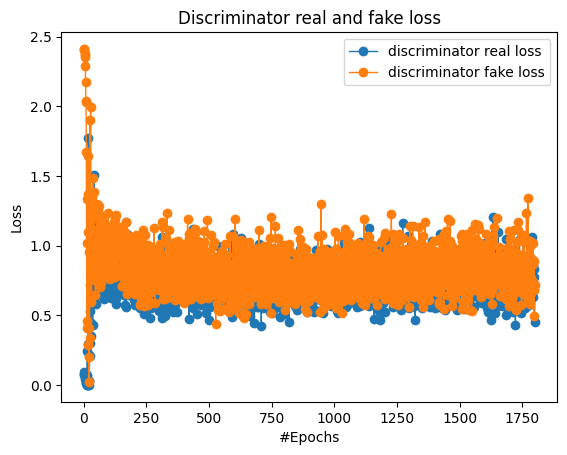

In [29]:

dreal_loss = t[0]
dfake_loss = t[1]
plt.plot(dreal_loss, label='discriminator real loss', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(dfake_loss, label='discriminator fake loss', marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("Discriminator real and fake loss")
plt.xlabel('#Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=( 1., 1.))


In [30]:
#############################################################################
#EVALUATE THE SUPERVISED DISCRIMINATOR ON TEST DATA
# This is the model we want as a classifier.
##################################################################
from keras.models import load_model
# load the model
disc_sup_trained_model = load_model('disc_sup_1800.h5')

# load the dataset
(_, _), (testX, testy) = load_data()

# expand to 3d, e.g. add channels
testX = expand_dims(testX, axis=-1)

# convert from ints to floats
testX = testX.astype('float32')

# scale from [0,255] to [-1,1]
testX = (testX - 127.5) / 127.5

# evaluate the model
_, test_acc = disc_sup_trained_model.evaluate(testX, testy, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))

# Predicting the Test set results
y_pred_test = disc_sup_trained_model.predict(testX)
prediction_test = np.argmax(y_pred_test, axis=1)

Test Accuracy: 93.140%
313/313 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step


<Axes: >

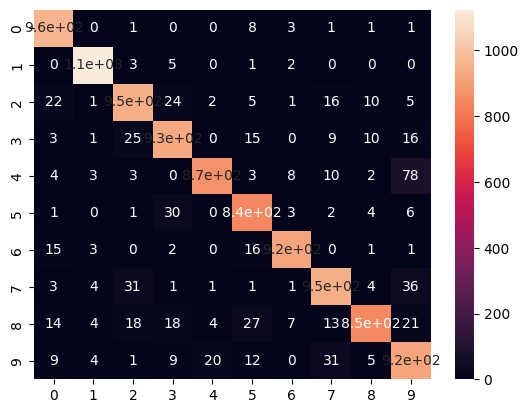

In [31]:
# Predicting the Test set results
y_pred_test = disc_sup_trained_model.predict(testX)
prediction_test = np.argmax(y_pred_test, axis=1)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(testy, prediction_test)
sns.heatmap(cm, annot=True)

1/1 [==============================] - 0s 102ms/step


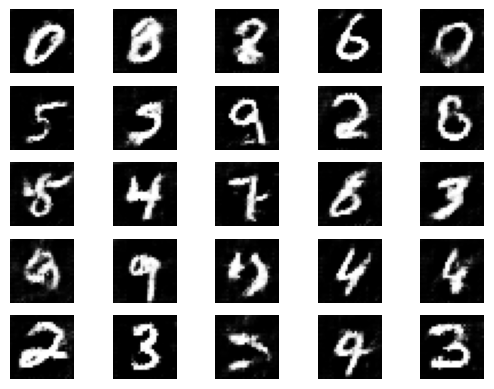

In [ ]:
#############################################################################
#PREDICT / GENERATE IMAGES using the generator, just for fun.
##################################################################

# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :], cmap='gray')
	plt.show()

# load model
gen_trained_model = load_model('gen_model_1800.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = gen_trained_model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)


# Inception score

In [39]:
def calculate_inception_score(generator, n_samples=500, n_split=10, eps=1E-16):
    # Generate synthetic images using the GAN generator
    synthetic_images = generator.predict(np.random.normal(0, 1, size=(n_samples, latent_dim)))

    # Convert images from uint8 to float32
    synthetic_images = synthetic_images.astype(np.float32)
    synthetic_images_resized = np.array([resize(img, (299, 299, 3), mode='reflect', anti_aliasing=True) for img in synthetic_images])
    # Preprocess synthetic images for InceptionV3 model
    synthetic_images = preprocess_input(synthetic_images)

    # Load the InceptionV3 model
    model = InceptionV3()

    # Predict class probabilities for synthetic images
    yhat = model.predict(synthetic_images_resized)

    # Enumerate splits of images/predictions
    scores = []
    n_part = synthetic_images.shape[0] // n_split

    for i in range(n_split):
        ix_start, ix_end = i * n_part, i * n_part + n_part
        p_yx = yhat[ix_start:ix_end]

        # Calculate p(y)
        p_y = np.expand_dims(p_yx.mean(axis=0), 0)

        # Calculate KL divergence using log probabilities
        kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))

        # Sum over classes
        sum_kl_d = kl_d.sum(axis=1)

        # Average over images
        avg_kl_d = np.mean(sum_kl_d)

        # Undo the log
        is_score = np.exp(avg_kl_d)

        # Store
        scores.append(is_score)

    # Average across images
    is_avg, is_std = np.mean(scores), np.std(scores)

    return is_avg, is_std

In [40]:
your_generator_model = gen_model

inception_score = calculate_inception_score(your_generator_model)

16/16 [==============================] - 7s 364ms/step


In [41]:
is_avg, is_std = inception_score
print("Inception Score (Average):", is_avg)
print("Inception Score (Standard Deviation):", is_std)

Inception Score (Average): 2.5053508
Inception Score (Standard Deviation): 0.17777967


# Grid Search CV for SGAN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Obtenez le chemin du répertoire de travail actuel
current_directory = os.getcwd()

# Spécifiez le nom du fichier que vous souhaitez déplacer
nom_fichier = "generated_plot_1800.png"

# Spécifiez le chemin du dossier cible
dossier_cible = "/content/drive/MyDrive/C:/Users/user/Desktop"

# Construisez le chemin complet du fichier source et du dossier cible
chemin_fichier_source = os.path.join(current_directory, nom_fichier)
chemin_dossier_cible = os.path.join(dossier_cible, nom_fichier)

# Déplacez le fichier vers le dossier cible
os.rename(chemin_fichier_source, chemin_dossier_cible)

FileNotFoundError: [Errno 2] No such file or directory: '/content/generated_plot_1800.png' -> '/content/drive/MyDrive/C:/Users/user/Desktop/generated_plot_1800.png'